In [ ]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import math
import networkx as nx
!pip install powerlaw
import powerlaw
import pandas as pd
from collections import defaultdict


In [ ]:
def find_clusters(image, min_cluster_size=0):
    # Convert the image to binary if not already
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Get the shape of the image
    rows, cols = binary_image.shape

    # Create a boolean array to keep track of visited pixels
    visited = np.zeros((rows, cols), dtype=bool)

    clusters = []

    # Directions for 8-connectivity
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),         (0, 1),
                  (1, -1), (1, 0), (1, 1)]

    # Helper function to perform DFS and find all connected pixels
    def dfs(x, y, cluster):
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            if visited[cx, cy]:
                continue
            visited[cx, cy] = True
            cluster.append((cx, cy))

            # Explore all 8-connected neighbors
            for dx, dy in directions:
                nx, ny = cx + dx, cy + dy
                if 0 <= nx < rows and 0 <= ny < cols and not visited[nx, ny] and binary_image[nx, ny] == 255:
                    stack.append((nx, ny))

    # Traverse through all pixels
    for i in range(rows):
        for j in range(cols):
            if binary_image[i, j] == 255 and not visited[i, j]:
                # Start a new cluster
                cluster = []
                dfs(i, j, cluster)

                # Add the cluster if it meets the minimum size requirement
                if len(cluster) >= min_cluster_size:
                    clusters.append(cluster)

    return clusters  # Return the coordinates of all white pixels in clusters



def visualize_clusters(image, clusters):
    # Create an empty image to visualize the clusters, with a white background
    cluster_image = np.zeros((*image.shape, 3), dtype=np.uint8) * 255

    # Function to generate a bright, noticeable color
    def generate_bright_color():
        color = np.random.randint(0, 256, 3).tolist()
        # Ensure the color is bright and far from white
        while np.mean(color) > 200:  # If too close to white, regenerate
            color = np.random.randint(0, 256, 3).tolist()
        return tuple(color)

    # Assign a unique bright color to each cluster
    for idx, cluster in enumerate(clusters):
        color = generate_bright_color()
        for (x, y) in cluster:
            cluster_image[x, y] = color

    return cluster_image

def create_adjacency_matrix(cluster):
    size = len(cluster)
    adjacency_matrix = np.zeros((size, size), dtype=int)

    # Convert list of pixel coordinates to a dictionary for quick lookup
    pixel_to_index = {pixel: idx for idx, pixel in enumerate(cluster)}

    # Directions for 8-connectivity
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),         (0, 1),
                  (1, -1), (1, 0), (1, 1)]

    # Fill the adjacency matrix
    for idx, (x, y) in enumerate(cluster):
        for dx, dy in directions:
            neighbor = (x + dx, y + dy)
            if neighbor in pixel_to_index:
                adjacency_matrix[idx, pixel_to_index[neighbor]] = 1

    return adjacency_matrix

def process_frame(frame, min_cluster_size=5):
    # Find the clusters for a single frame
    clusters = find_clusters(frame, min_cluster_size)

    # Generate adjacency matrices for each cluster
    adjacency_matrices = [create_adjacency_matrix(cluster) for cluster in clusters]

    # Visualize the clusters
    cluster_image = visualize_clusters(frame, clusters)

    return clusters, adjacency_matrices, cluster_image  # Return clusters, adjacency matrices, and visualization

def display_clusters(frame, clusters, cluster_image):
    # Create a new frame with a white background
    white_bg_frame = np.ones_like(frame) * 255  # White background
    white_bg_frame[frame == 255] = 0  # Invert only white pixels to black, keep others white

    # Create cluster_image_white and set non-zero pixels to white
    cluster_image_white = np.zeros_like(cluster_image)
    cluster_image_white[cluster_image == 0] = 255  # Invert only non-zero pixels to white, keep others black

    # Convert the grayscale image to RGB for better display with matplotlib
    white_bg_frame_rgb = cv2.cvtColor(white_bg_frame, cv2.COLOR_GRAY2RGB)
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    plt.imsave("visualised_clusters.png", cluster_image) # Save the image

    plt.imshow(cluster_image)
    plt.axis('off')
    plt.show()

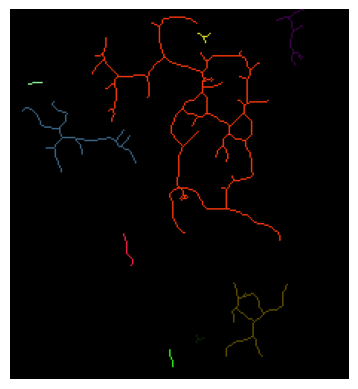

In [ ]:

img = cv2.imread('/content/MAX_C2-6Ge_1.1-2(Skel).jpg', cv2.IMREAD_GRAYSCALE)

# Process the image
clusters, adjacency_matrices, cluster_image = process_frame(img)

# Display the clusters
display_clusters(img, clusters, cluster_image)

In [ ]:
# prompt: save the image as visualised clusters

import matplotlib.pyplot as plt

def display_clusters(frame, clusters, cluster_image):
    # ... (rest of your code)

    plt.imsave("visualised_clusters.png", cluster_image) # Save the image
    plt.imshow(cluster_image)
    plt.axis('off')
    plt.show()

In [ ]:

def display_adjacency_matrices(adjacency_matrices):
  """Displays the adjacency matrices for each cluster."""
  for i, matrix in enumerate(adjacency_matrices):
      print(f"Adjacency Matrix for Cluster {i+1}:")
      print(matrix)
      print("\n")

display_adjacency_matrices(adjacency_matrices)


Adjacency Matrix for Cluster 1:
[[0 1 0 ... 0 1 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


Adjacency Matrix for Cluster 2:
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]]


Adjacency Matrix for Cluster 3:
[[0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 1 0 0 1 0 0 0 1]
 [0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 1 0 0 0 1 0 0 0 0]]


Adjacency Matrix for Cluster 4:
[[0 1 0 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0]]


Adjacency Matri

In [ ]:
def display_networkx(adjacency_matrices):
  """Displays a mathematical representation for each cluster using NetworkX."""
  for i, matrix in enumerate(adjacency_matrices):
      print(f"Network Graph for Cluster {i+1}:")

      graph = nx.from_numpy_array(matrix)

      nx.draw(graph, with_labels=True, node_size=10, node_color='skyblue', font_size=0)
      plt.title(f"Cluster {i+1}")
      plt.show()

In [ ]:
def simplify_adjacency_matrix(adj_matrix):
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(adj_matrix))

    # Find all nodes with degree 2
    degree_dict = dict(G.degree())
    nodes_degree_2 = [node for node, degree in degree_dict.items() if degree == 2]

    # Track visited nodes to avoid re-processing
    visited = set()

    for node in nodes_degree_2:
        if node not in visited:
            # Start by getting the neighbors of this node
            neighbors = list(G.neighbors(node))

            # If this node has exactly 2 neighbors, it's part of a chain
            if len(neighbors) == 2:
                chain = [node]
                visited.add(node)

                # Trace the entire chain of degree-2 nodes
                while True:
                    # Look at the neighbors of the current node in the chain
                    next_node = None
                    for neighbor in neighbors:
                        if G.degree[neighbor] == 2 and neighbor not in visited:
                            next_node = neighbor
                            break
                    if next_node is None:
                        break

                    chain.append(next_node)
                    visited.add(next_node)
                    neighbors = list(G.neighbors(next_node))

                # Collapse the chain into a single node
                if len(chain) > 1:
                    start_node = chain[0]
                    end_node = chain[-1]

                    # Reconnect start_node and end_node's neighbors
                    start_neighbors = list(G.neighbors(start_node))
                    end_neighbors = list(G.neighbors(end_node))

                    for neighbor in start_neighbors:
                        if neighbor != chain[1]:
                            G.add_edge(start_node, neighbor)

                    for neighbor in end_neighbors:
                        if neighbor != chain[-2]:
                            G.add_edge(start_node, neighbor)

                    # Remove internal nodes of the chain
                    for node_in_chain in chain[1:]:
                        G.remove_node(node_in_chain)

    # Get the simplified adjacency matrix
    simplified_adj_matrix = nx.to_numpy_array(G)
    return simplified_adj_matrix

In [ ]:

def remove_triangles(adj_matrix):
    """Simplifies the adjacency matrix by removing edges in closed circuit triangles.
    Removes the edge between the two furthest nodes in each triangle.
    """
    G = nx.from_numpy_array(np.array(adj_matrix))
    # Get all triangles in the graph
    triangles = list(nx.enumerate_all_cliques(G))
    triangles = [triangle for triangle in triangles if len(triangle) == 3]  # Filter for triangles only

    edges_to_remove = set()
    for triangle in triangles:
        # Find the distance between nodes in the triangle
        node1, node2, node3 = triangle
        distances = {
            (node1, node2): nx.shortest_path_length(G, source=node1, target=node2),
            (node1, node3): nx.shortest_path_length(G, source=node1, target=node3),
            (node2, node3): nx.shortest_path_length(G, source=node2, target=node3)
        }

        # Find the edge with the largest distance
        max_dist = 0
        edge_to_remove = None
        for edge, dist in distances.items():
            if dist > max_dist:
                max_dist = dist
                edge_to_remove = edge

        # Add the edge to the set of edges to remove
        edges_to_remove.add(tuple(sorted(edge_to_remove)))


    for edge in edges_to_remove:
        if G.has_edge(edge[0], edge[1]):
            G.remove_edge(edge[0], edge[1])

    simplified_adj_matrix = nx.to_numpy_array(G)
    return simplified_adj_matrix


Network Graph for Cluster 2 (without triangles):


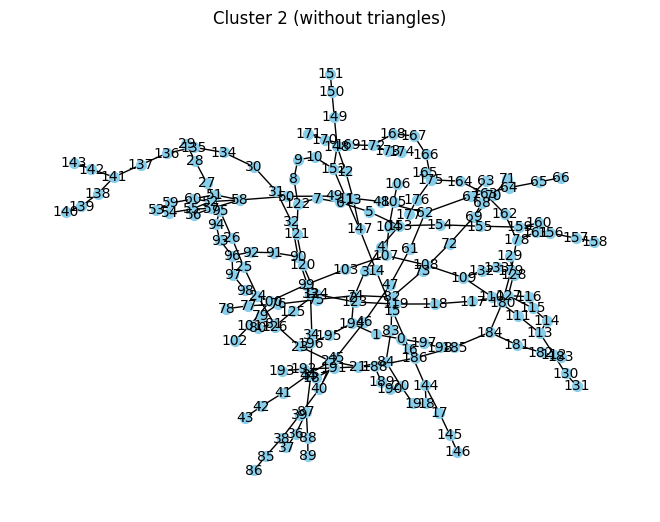

Number of closed circuits: 30


Network Graph for Cluster 1:


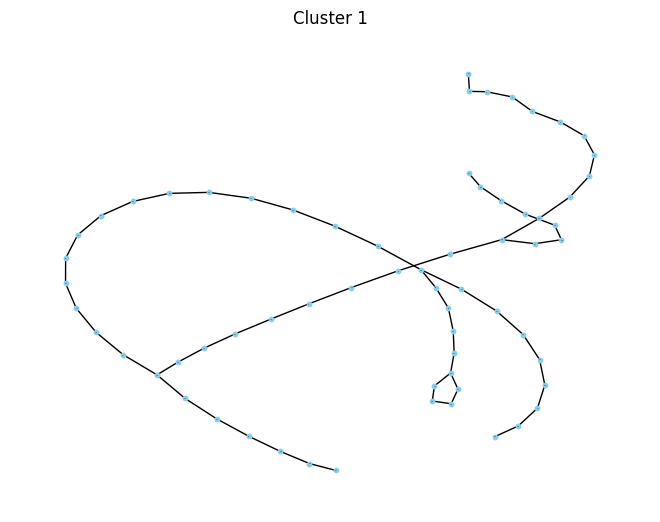

Network Graph for Cluster 2:


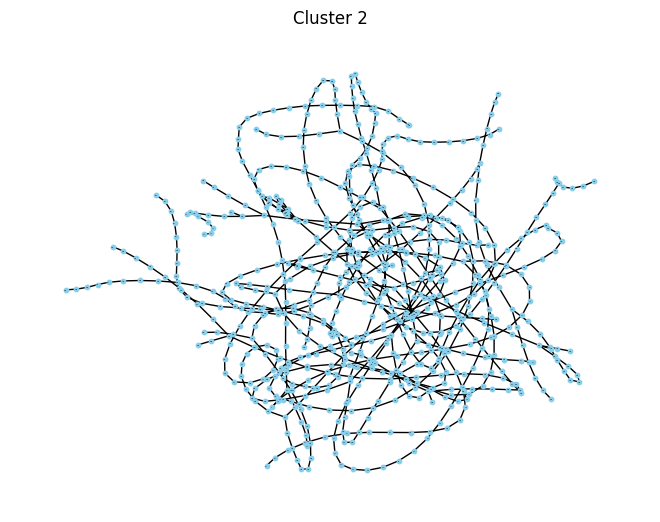

Network Graph for Cluster 3:


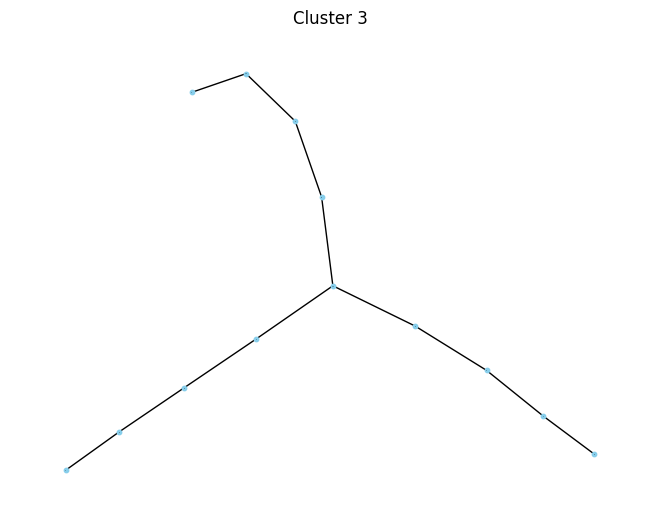

Network Graph for Cluster 4:


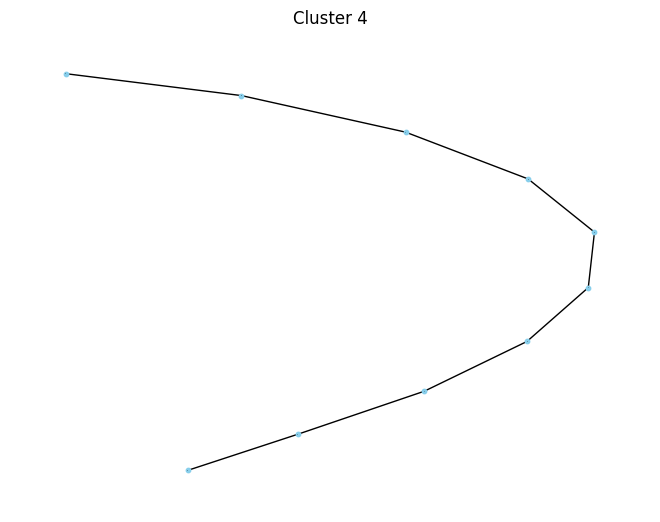

Network Graph for Cluster 5:


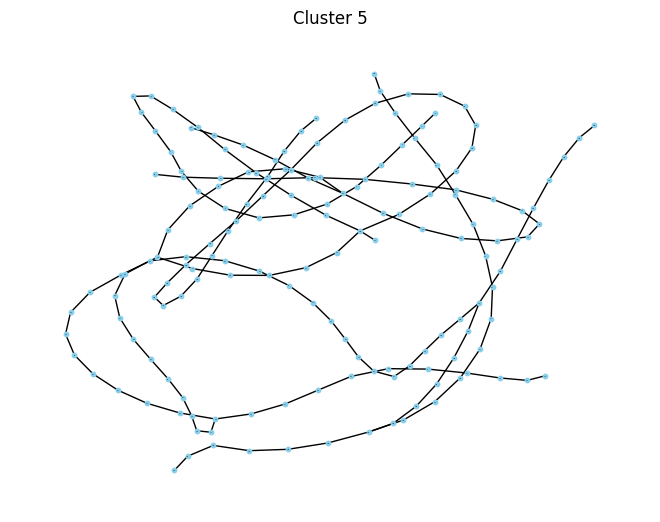

Network Graph for Cluster 6:


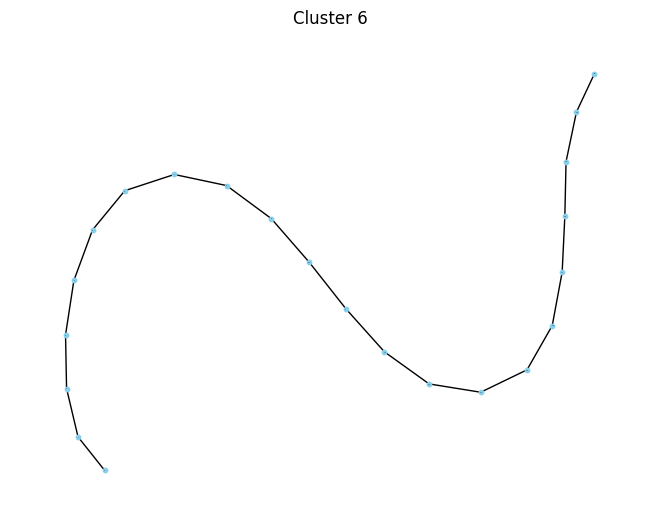

Network Graph for Cluster 7:


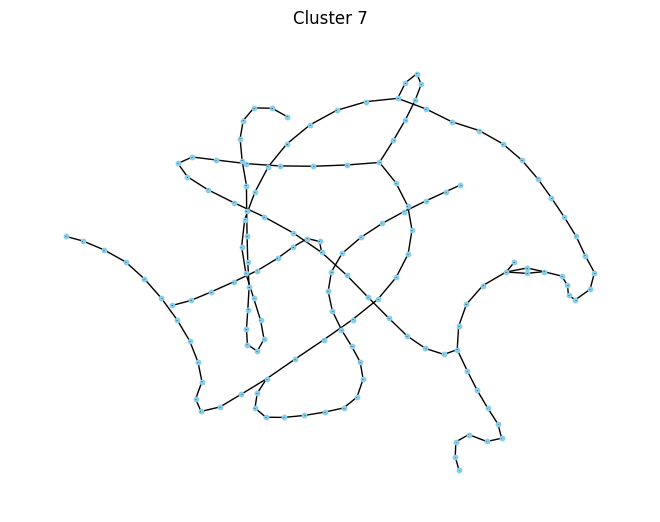

Network Graph for Cluster 8:


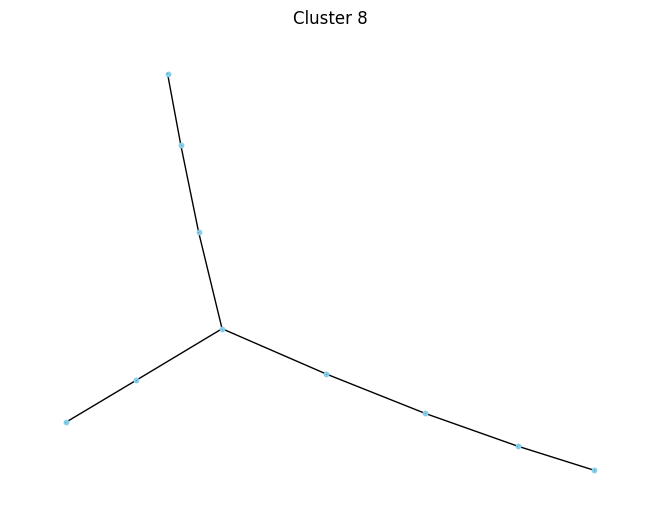

Network Graph for Cluster 9:


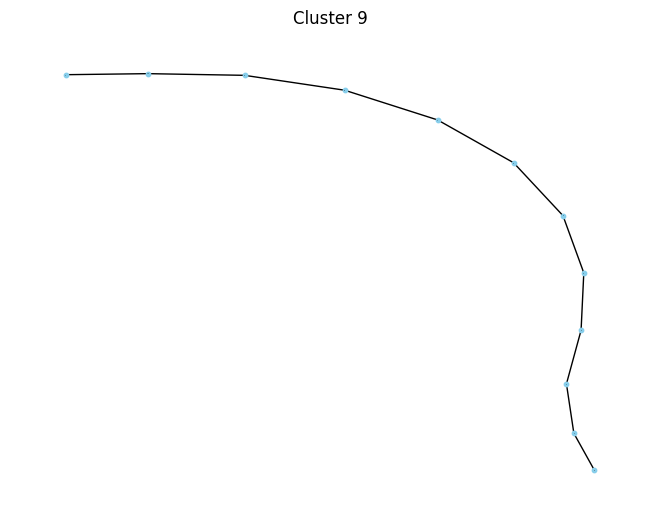

In [ ]:
simplified_adjacency_matrices = []
for adj_matrix in adjacency_matrices:
  simplified_adj_matrix = remove_triangles(adj_matrix)
  simplified_adjacency_matrices.append(simplified_adj_matrix)

# Display the simplified adjacency matrices using NetworkX
display_networkx(simplified_adjacency_matrices)

In [ ]:
# prompt: How many closed circuits does "simplified_matrix_without_triangles" have?

import networkx as nx

def count_closed_circuits(adjacency_matrix):
  """Counts the number of closed circuits (cycles) in a graph represented by an adjacency matrix."""
  graph = nx.from_numpy_array(adjacency_matrix)
  cycles = list(nx.simple_cycles(graph))
  return len(cycles)

if len(simplified_adjacency_matrices) >= 2:
  matrix = simplified_adjacency_matrices[1]
  simplified_matrix_without_triangles = remove_triangles(matrix)

  num_circuits = count_closed_circuits(simplified_matrix_without_triangles)
  print("Number of closed circuits:", num_circuits)
else:
  print("There are fewer than 2 clusters in the image.")

Number of closed circuits: 36


Network Graph for Cluster 2 (without triangles):


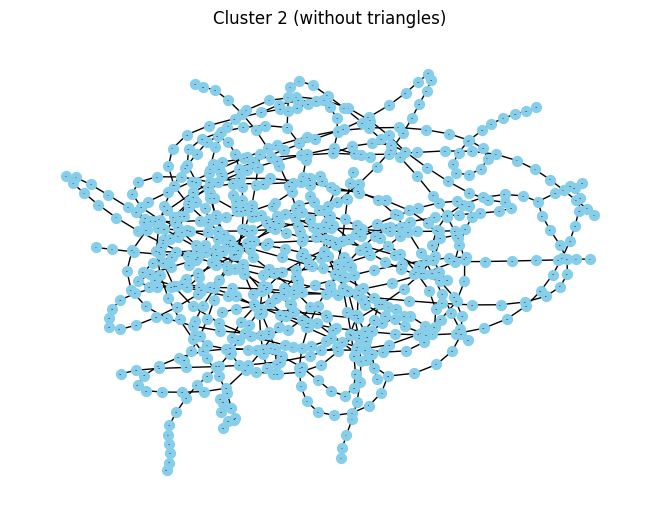

In [ ]:
if len(simplified_adjacency_matrices) >= 2:
  matrix = simplified_adjacency_matrices[1]  # Assuming cluster indexing starts at 0
  simplified_matrix_without_triangles = remove_triangles(matrix)

  print(f"Network Graph for Cluster 2 (without triangles):")

  graph = nx.from_numpy_array(simplified_matrix_without_triangles)  # Create a graph from the adjacency matrix

  # Visualize the graph using NetworkX
  nx.draw(graph, with_labels=True, node_size=50, node_color='skyblue', font_size=0)
  plt.title(f"Cluster 2 (without triangles)")
  plt.show()


In [ ]:

def calculate_euler_characteristic(adjacency_matrix):
    """Calculates the Euler characteristic of a graph represented by an adjacency matrix."""
    graph = nx.from_numpy_array(adjacency_matrix)

    num_vertices = graph.number_of_nodes()
    num_edges = graph.number_of_edges()

    simplified_matrix = remove_triangles(adjacency_matrix)
    simplified_graph = nx.from_numpy_array(simplified_matrix) # Convert to Graph
    num_faces = len(nx.cycle_basis(simplified_graph))

    euler_characteristic = num_vertices - num_edges + num_faces
    return euler_characteristic


for i, matrix in enumerate(adjacency_matrices):
    euler_char = calculate_euler_characteristic(matrix)
    print(f"Euler Characteristic for Cluster {i + 1}: {euler_char}")

Euler Characteristic for Cluster 1: -7
Euler Characteristic for Cluster 2: -44
Euler Characteristic for Cluster 3: -1
Euler Characteristic for Cluster 4: 1
Euler Characteristic for Cluster 5: -4
Euler Characteristic for Cluster 6: 1
Euler Characteristic for Cluster 7: -6
Euler Characteristic for Cluster 8: 0
Euler Characteristic for Cluster 9: 1


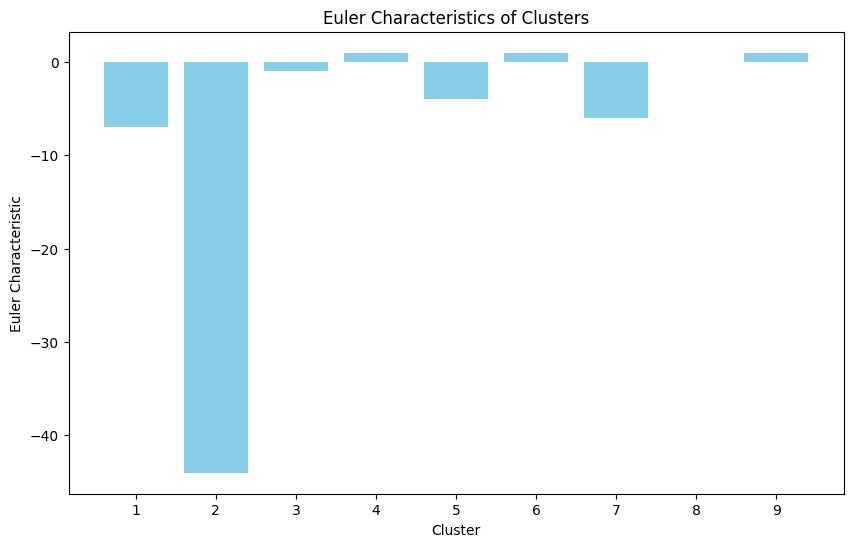

In [ ]:


def plot_euler_characteristics(adjacency_matrices):
    """Plots the Euler characteristics of multiple clusters as a bar chart."""
    euler_characteristics = []
    for i, matrix in enumerate(adjacency_matrices):
        euler_char = calculate_euler_characteristic(matrix)
        euler_characteristics.append(euler_char)

    clusters = [i + 1 for i in range(len(adjacency_matrices))]

    plt.figure(figsize=(10, 6))
    plt.bar(clusters, euler_characteristics, color='skyblue')
    plt.xlabel("Cluster")
    plt.ylabel("Euler Characteristic")
    plt.title("Euler Characteristics of Clusters")
    plt.xticks(clusters)
    plt.show()


plot_euler_characteristics(adjacency_matrices)

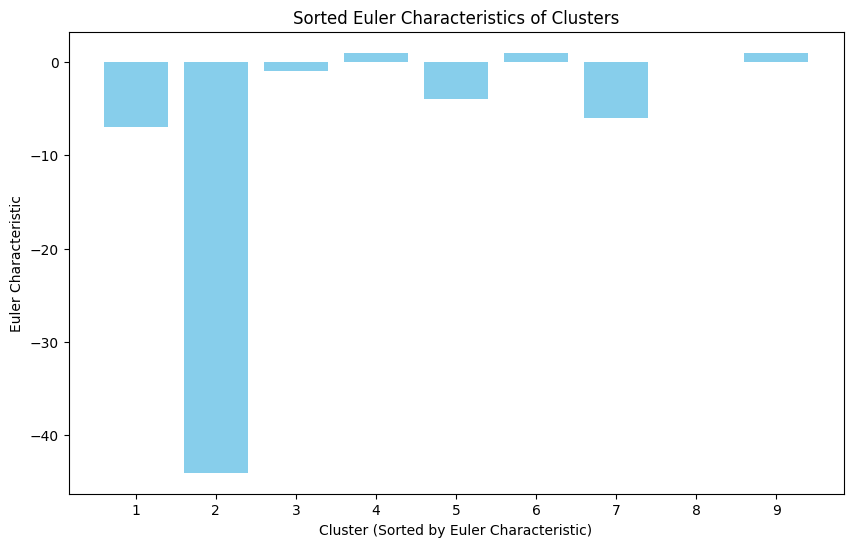


Original vs. Sorted Cluster Indices:
   Cluster  EulerCharacteristic
0        1                   -7
1        2                  -44
2        3                   -1
3        4                    1
4        5                   -4
5        6                    1
6        7                   -6
7        8                    0
8        9                    1

Sorted Cluster Indices:
   Cluster  EulerCharacteristic
1        2                  -44
0        1                   -7
6        7                   -6
4        5                   -4
2        3                   -1
7        8                    0
3        4                    1
5        6                    1
8        9                    1


In [ ]:
# prompt: sort the Euler characteristics with thier cluster index and plot the sorted Euler characteristic, show how the indecies changed

import pandas as pd
import matplotlib.pyplot as plt

def plot_sorted_euler_characteristics(adjacency_matrices):
    """Sorts Euler characteristics, plots them, and shows index changes."""
    euler_characteristics = []
    for i, matrix in enumerate(adjacency_matrices):
        euler_char = calculate_euler_characteristic(matrix)
        euler_characteristics.append(euler_char)

    # Create a DataFrame for easier sorting and visualization
    df = pd.DataFrame({'Cluster': range(1, len(adjacency_matrices) + 1),
                       'EulerCharacteristic': euler_characteristics})

    # Sort the DataFrame by Euler Characteristic
    df_sorted = df.sort_values('EulerCharacteristic')

    # Plot the sorted Euler characteristics
    plt.figure(figsize=(10, 6))
    plt.bar(df_sorted['Cluster'], df_sorted['EulerCharacteristic'], color='skyblue')
    plt.xlabel("Cluster (Sorted by Euler Characteristic)")
    plt.ylabel("Euler Characteristic")
    plt.title("Sorted Euler Characteristics of Clusters")
    plt.xticks(df_sorted['Cluster'])  # Use the sorted cluster numbers for x-ticks
    plt.show()

    # Display how the indices changed (original vs. sorted)
    print("\nOriginal vs. Sorted Cluster Indices:")
    print(df)
    print("\nSorted Cluster Indices:")
    print(df_sorted)


plot_sorted_euler_characteristics(adjacency_matrices)

In [ ]:
# prompt: Store this true data in an xlsx spread sheet

import pandas as pd

# Assuming you have the following data from your code:
#   - clusters: A list of clusters, where each cluster is a list of (x, y) coordinates
#   - adjacency_matrices: A list of adjacency matrices for each cluster
#   - simplified_adjacency_matrices: Simplified matrices
#   - euler_characteristics: A list of Euler characteristics for each cluster
#   - num_circuits: A number representing the closed circuits


# Create a dictionary to store the data
data = {
    "Cluster_index": list(range(1, len(adjacency_matrices) + 1)), # Assuming cluster numbering starts from 1
    "Euler_characteristic": [calculate_euler_characteristic(matrix) for matrix in adjacency_matrices]
}

# Create a DataFrame
df = pd.DataFrame(data)


# Save the DataFrame to an Excel file
df.to_excel("cluster_analysis.xlsx", index=False)

print("Data saved to cluster_analysis.xlsx")

Data saved to cluster_analysis.xlsx
